In [43]:
import math
import random
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn import datasets

import scipy
from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

sns.reset_orig()


noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 0.8
test_split = 0.2
repeats = 100

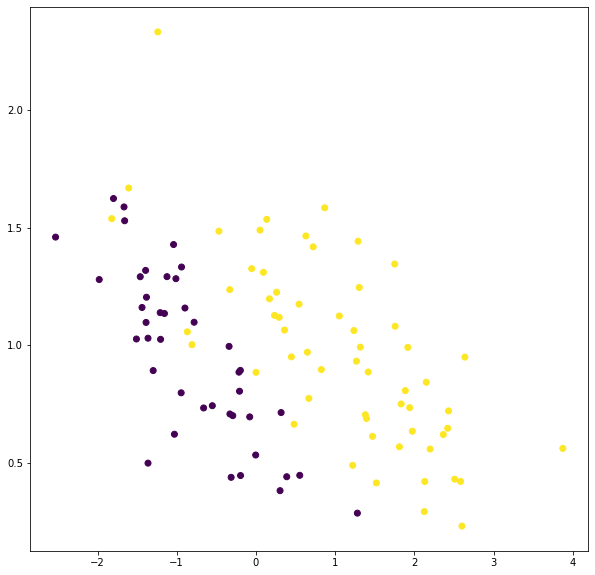

In [44]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

In [45]:
from scipy.optimize import LinearConstraint, Bounds, minimize


def linear_kernel(x1, x2, *args):
    return np.dot(x1, x2)


def decision_function(x, w, b):

    return np.dot(x, w) + b


def lagrange_function(alpha, x, y2, kernel, degree, gamma):
    res = 0
    for i in range(alpha.shape[0]):
        for j in range(alpha.shape[0]):
            res += alpha[i] * alpha[j] * y2[i] * y2[j] * kernel(x[i], x[j], degree, gamma, 0)

    return  0.5 * res - sum(alpha)


def fit(x_train, y_train2, kernel, degree=1, gamma=0.1, C=1.0):
    ZERO = 1e-5

    n, m = x_train.shape
    # np.random.seed(self.random_state)
    alpha_start = np.random.uniform(0, C, size=n)
    # alpha_start = np.zeros(n)
    linear_constraint = LinearConstraint(A=y_train2, lb=[0], ub=[0])
    bounds = Bounds(np.zeros(n), np.full(n, C-ZERO))
    result = minimize(
        fun=lagrange_function,
        x0=alpha_start,
        args=(x_train, y_train2, kernel, degree, gamma),
        # hess=BFGS(),
        constraints=[linear_constraint],
        bounds=bounds)
    alpha_ = result.x
    alpha_[alpha_ < ZERO] = 0
    support_ = np.where(alpha_ > ZERO)[0]
    support_vectors_ = x_train[support_]
    support_labels = y_train2[support_]
    train_vectors_ = x_train
    train_labels = y_train2

    coef_ = np.zeros(m)
    for i in support_:
        coef_ += alpha_[i] * y_train2[i] * x_train[i]

    intercept_ = 0
    # c_num = self.C - ZERO
    for i in support_:
        intercept_ += y_train2[i] - np.dot(coef_, x_train[i])
    intercept_ /= len(support_)
    print(coef_, intercept_)
    return coef_, intercept_



def predict(x, w, b):
    return np.sign(decision_function(x, w, b))

In [46]:

# mdl = MySVM(kernel='linear', degree=2)
#
#
# fit(X_train, y_train, linear_kernel, degree=2, gamma=0.1, C=1.0)
# pred1 = mdl.predict(X_test)
#
# mesh_data = c_[xx.ravel(), yy.ravel()]
#
# predict = mdl.predict(mesh_data)
# predict = predict.reshape(xx.shape)
# plt.figure(figsize=(10, 10))
# plt.contourf(xx, yy, predict, alpha=0.4, cmap='ocean')
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
#
# cm_model = confusion_matrix(y_test, pred1, labels=[-1, 1])
# tn_model = cm_model[0][0]
# fn_model = cm_model[0][1]
# tp_model = cm_model[1][1]
# fp_model = cm_model[1][0]
# ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')
#
# fpr, tpr, roc_auc = roc_curve(y_test, mdl.decision_function(X_test))
#
# rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
# rok_model.plot()

In [47]:
theta, bias = fit(X_train, y_train, kernel=linear_kernel, degree=2, gamma=0.1, C=1.0)

[1.74525062 2.73651222] -2.380004188957871


In [48]:
predict_var = predict(X_test, theta, bias)

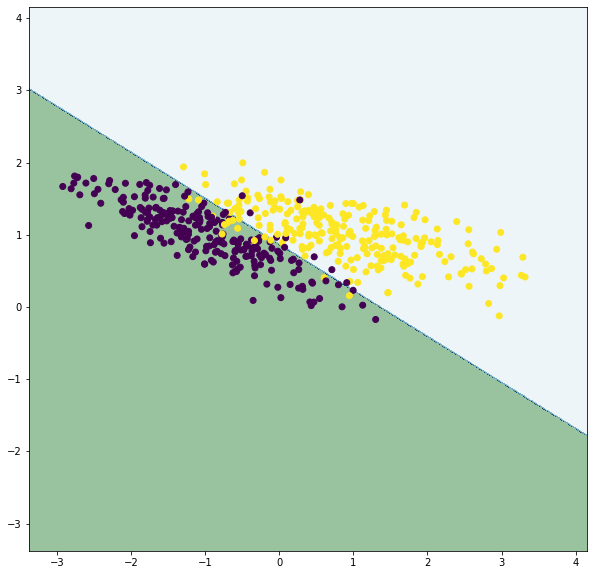

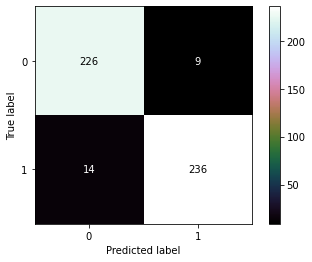

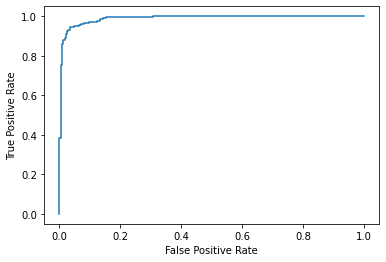

In [49]:
mesh_data = c_[xx.ravel(), yy.ravel()]


predict_cntr = predict(mesh_data, theta, bias)
predict_cntr = predict_cntr.reshape(xx.shape)
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, predict_cntr, alpha=0.4, cmap='ocean')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

cm_model = confusion_matrix(y_test, predict_var, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, decision_function(X_test, theta, bias))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()